## OCR

In [540]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2

Funkcja do tworzenia obrazy z tekstem.
Przyjmuje tekst z określoną wielkością fonta, ostateczny rozmiar obrazu jest tak dopasowywany, aby tekst się zmieścił.
Przy testowaniu OCR zakładam, że tekst ma font_size równy przynajmiej 20.
W testach używam dwóch czcionek szeryfowych (Times New Roman i Courier) i dwóch czcionek bezszeryfowych (Arial i Open-sans).
Czcionka Courier jest do tego czcionką o stałej szerokości znaku.
Obraz ma także padding na tyle duży, żeby tekst dało się potem obrócić bez straty informacji i bez zmieniania wymiarów obrazu.


In [329]:
def draw_multiline_text(text, size=(800, 600), font_size=40, font='arial', show=False):

    def fit_horizontal():
        return upper_x > padding_x and lower_x < size[0] - padding_x

    def fit_vertical():
        return upper_y > padding_y and lower_y < size[1] - padding_y

    padding_x = size[0] // 7
    padding_y = size[1] // 7
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
    if not fit_horizontal():
        return draw_multiline_text(text, size = (size[0] + 100, size[1]),
                                   font_size=font_size, font=font, show=show)
    if not fit_vertical():
        return draw_multiline_text(text, size = (size[0], size[1] + 100),
                                   font_size=font_size, font=font, show=show)

    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

Zbiór znaków do rozpoznawania do liter małych i dużych, cyfr i kilku znaków interpunkcyjnych.
Czasami przy porównywaniu wyników nie będę w tym zbiorze uwzględniał kropki i przecinka, gdyż
te znaki są wykrywane w wielu miejscach na obrazie i znacząco zmieniają wynik.

In [427]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ".,?!/-~:()[]"

Znaki któych nie uwzględniam zastępuje spacjami.

In [428]:
def filter_text(text):
    return "".join(list(map(lambda x: x if x in characters or x == '\n' else " ", text)))

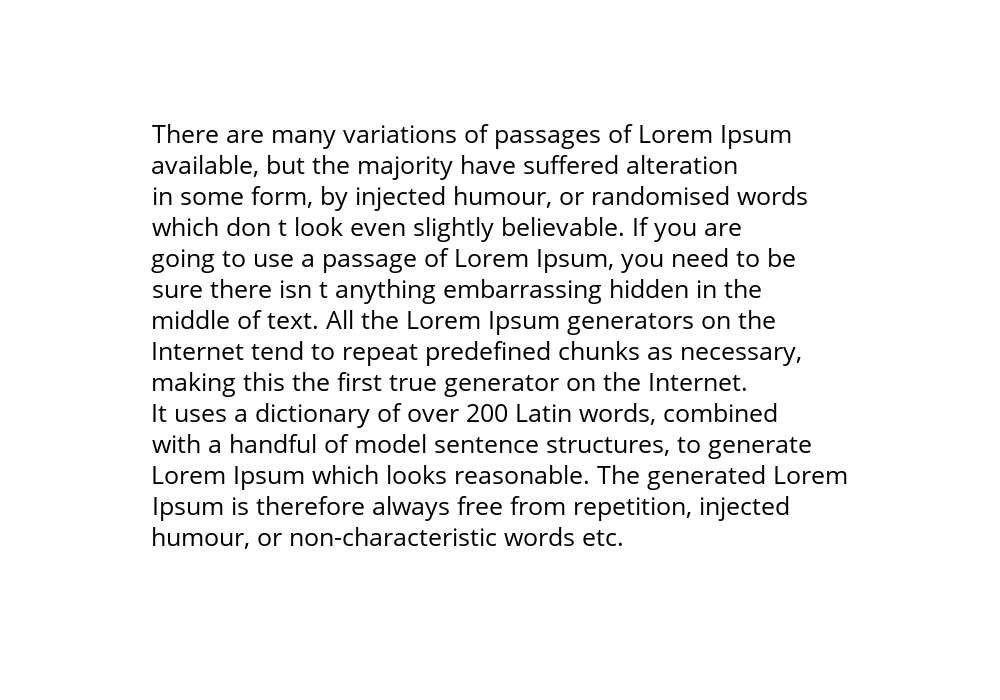

In [429]:
txt = '''There are many variations of passages of Lorem Ipsum
available, but the majority have suffered alteration
in some form, by injected humour, or randomised words
which don't look even slightly believable. If you are
going to use a passage of Lorem Ipsum, you need to be
sure there isn't anything embarrassing hidden in the
middle of text. All the Lorem Ipsum generators on the
Internet tend to repeat predefined chunks as necessary,
making this the first true generator on the Internet.
It uses a dictionary of over 200 Latin words, combined
with a handful of model sentence structures, to generate
Lorem Ipsum which looks reasonable. The generated Lorem
Ipsum is therefore always free from repetition, injected
humour, or non-characteristic words etc.
'''
txt = filter_text(txt)
out, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=25, show=True)

Funkcja do obracania zdjęcia

In [95]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

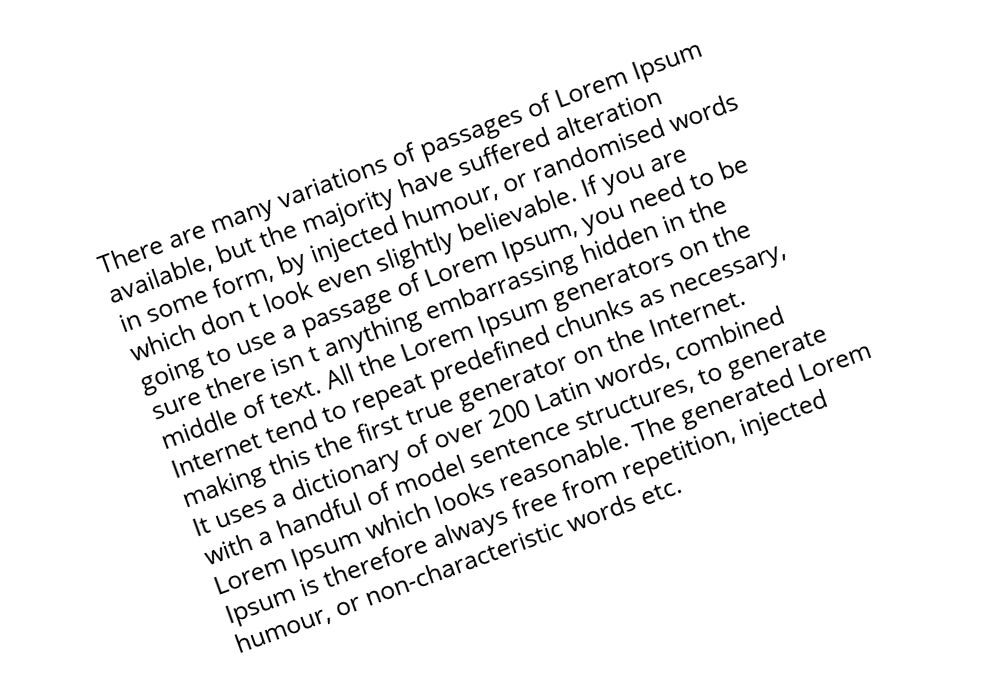

In [96]:
display(rotate_image(out, 20))

Rysowanie pojedynczych liter.
Są rysowane dla konkretnej wielkości czcionki. Używam ich potem jako wzorców przy OCR.

In [97]:
def remove_black_padding(img):
    matrix = np.array(img)
    matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char.lower() == 'j':
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

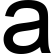

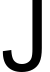

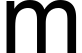

In [98]:
for letter in ['a', 'J', '!', 'm']:
    draw_single_character(letter, 99, font='arial', show=True)

In [163]:
def get_all_character_images(font, fontsize): # Rysowanie wszystkich znaków z użyciem powyższej funkcji
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))

def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img, dtype=float)

def matrix_to_image(matrix):
    return Image.fromarray(matrix).convert('L')

def invert_colors(matrix):
    return 255 - matrix

def normalize(matrix):
    """
    Sprowadzenie wartości z macierzy do wartości z przedziału 0-255
    na przykład po zastosowaniu SVD
    """
    return 255 * (matrix / np.max(matrix))


def threshold(matrix, k=150):
    """Zamiana wartości macierzy na binarne"""
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


Redukcja szumu.
Jako, że obrazy są generowane a nie skanowane nie występuje na nich szum. Użycie SVD ma więc efekt odwrotny do zamierzonego.
Funkcja ta może być użyta, aby obraz z tekstem wyglądał bardziej naturalnie

In [100]:
def reduce_noise(img, k = 160):
    matrix = img_to_matrix(img)
    u, s, v = np.linalg.svd(matrix)
    mat = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')

### Wyrównywanie tekstu

Algorytm wyrównywania tekstu polega na obracaniu obrazu i zliczaniu poziomych białych linii. Jeśli tekst jest wyrównany to takich linii będzie najwięcej.
Wcześniej macierz jest zamieniana na binarną. Zakładam, że obrazy są obrócone o kąt który jest liczbą całkowitą. ALgorytm testuje więc za każdym razem 180 możliwości poprawy.

In [114]:

def count_horizontal_lines(img):
    """
    Zliczanie poziomych linii,
    uwzględniam jedynie białe linie, które znajdują się pomiędzy liniami, które zawierają czarne piksele
    """
    matrix = invert_colors(threshold(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    return matrix.shape[0] - np.count_nonzero(matrix) - np.argmax(matrix) - np.argmax(matrix[::-1])

def count_something(img):
    """Liczenie pikseli z prawej strony obrazy"""
    matrix = invert_colors(threshold(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    scores = np.zeros(180)
    for i in range(180):
        rotated = rotate_image(img, i)
        scores[i] = count_horizontal_lines(rotated)

    best_angle = np.argmax(scores)
    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


Widać jednak, że istnieją dwa ustawienia w których ilość poziomych linii jest taka sama. Jest to w przypadku, gdy tekst jest wyrównany albo obrócony o 180 stopni.(Jak na zdjęciu poniżej)

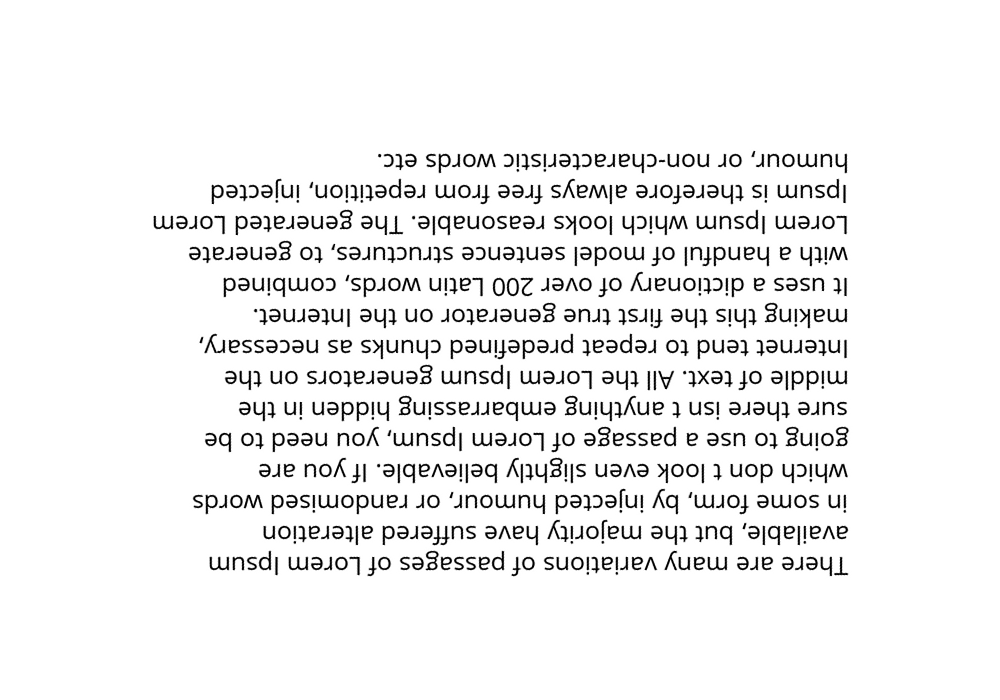

In [103]:
display(correct_angle(rotate_image(out, 20)))

Można zauważyć, że jeżeli obraz reprezentuje jakiś faktyczny tekst to zazwyczaj po prawej stronie jest więcej niezajmowanej przestrzeni, gdyż tekst jest wyrównany do lewej strony. Zliczam więc ilość białych pikseli do wystąpienia pierwszego czarnego piksela dla każdej linii zaczynając od prawej strony obrazy.

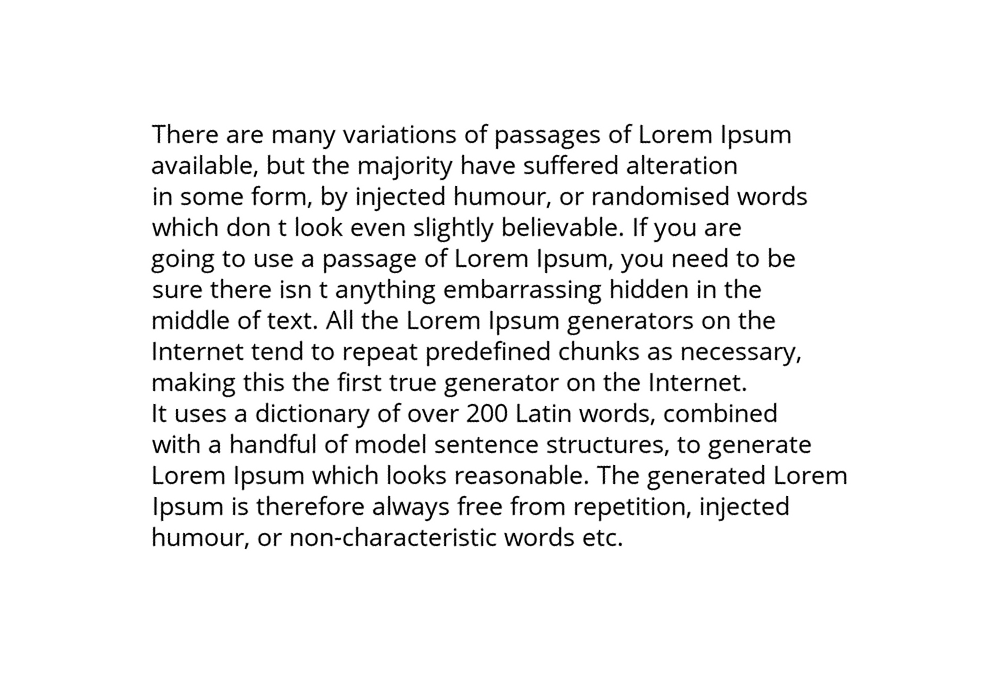

In [115]:
display(correct_angle(rotate_image(out, 20)))

Po zastosowaniu takiej korekty dla większości przypadków jest już znajdowane poprawne ustawienie obrazu.
Algorytm ten ma jednak wiele wad, obraca jedynie o kąty będące liczbą całkowitą i musi sprawdzić 180 przypadków, przez co nie jest specjalnie szybki.
Kwestia stwierdzania czy obraz jest obrócony o 180 stopnie można by rozwiązać szukając na obrazie liter normalnych i obróconych i decydować na podstawie tego których liter wystąpiło więcej.

## Optical character recognition

W przeciwieństwie do zad1 i szukania literki e tutaj nigdy nie mamy pewności czy dana litera występuje w podanym na zdjęciu tekście, dlatego przy wykrywaniu litery na obrazie jako maksymalną korelację nie przyjmuje maksymalnej wartości się pojawiła, lecz korelację szukanego wzorca samego ze sobą, czyli kwadrat normy Frobeniusa danej macierzy.

In [390]:
def convolve_images(pattern, image):
    """Funkcja licząca splot dwóch obrazów"""
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))


def find_occurrences(pattern, image, eps=0.05):
    """
    Funkcja zwraca wszystkie potencjalne wystąpienia patternu na zdjęciu.
    Parametr eps określa jak przedział korelacji uznawać za wystąpienie danej liczby.
    Jego wartość jest dobierana empirycznie i jej 'dobra' wartość zmienia się w zależności od rodzaju i wielkości czcionki,
    a także tego, czy rozpoznawany obraz był wcześniej obrócony, przez co wygląd liter mógł ulec zmianom
    """
    convolution = convolve_images(pattern, image)
    max_correlation = np.sum(pattern * pattern)
    return list(zip(*np.where(np.abs(convolution - max_correlation) < eps * max_correlation)))

Największym problemem przy implementacji OCR było wykrywanie liter, które często błędnie wykrywały się wewnątrz innych liter, np. n wewnątrz h albo c wewnątrz o. Znak kropki i przecinka wykrywał się w praktycznie w każdym miejscu w tekście. Są też charakterystyczne znaki, które praktycznie zawsze są poprawnie rozpoznawane. Można w takim razie przeszukiwanie tekstu zacząć od znajdywania tych charakterystycznych liter i dopiero potem przechodzić do tych trudniejszych. Maleje wtedy szansa niepoprawnej klasyfikacji. Na przkład jeśli n wykrywa się na literze h, a h już nie wykrywa się na literze n to najpierw powinno szukać się litery h, a później litery n. Główna trudność zadania sprowadza się wtedy do znalezienia odpowiedniej kolejności.

Można zbudować skierowany graf zależności, gdzie wierzchołkami są znaki, a krawędź z v do u istnieje wtedy, gdy litera u jest niepoprawnie wykrywana w miejscu litery v. Taka krawędź mówi nam, że w optymalnym porządku litera v powinna poprzedzać literę u. Poniższa funkcja buduje właśnie taki graf.

In [542]:
import networkx as nx

def prepare_images(images):
    """
    Zamiana obrazów na macierze z jednoczesnym odwróceniem kolorów i zamianą na macierz binarną.
    """
    return list(
        map(lambda x: threshold(x, 220),
        map(invert_colors,
        map(img_to_matrix, images)))
    )

def create_graph(font, font_size, chars, eps=0.05):
    """
    Funkcja buduje graf dla danej czcionki i rozmiaru. Lista chars zawiera listę macierzy reprezentujących pojedyncze litery.
    Lista images jest praktycznie tym samym, ale obraz litery posiada większy padding. Krawędź z v do u powstanie, jeśli
    char[u] zostanie wykryte gdzieś w images[v].
    """
    images = [draw_multiline_text(c, size=(font_size*2, font_size*2), font=font, font_size=font_size)[0] for c in characters]
    images = prepare_images(images)
    graph = nx.DiGraph()
    graph.add_nodes_from(range(len(images)))
    for i, pattern in enumerate(chars):
        for j, image in enumerate(images):
            if i != j and find_occurrences(pattern, image, eps):
                graph.add_edge(j, i)
    return graph

In [446]:
%%time
g = create_graph('open-sans', 30, prepare_images(get_all_character_images('open-sans', 30)))

CPU times: total: 3.08 s
Wall time: 3.97 s


In [447]:
print(g)
try:
    nx.find_cycle(g)
    print("Graph has cycles")
except:
    print("No cycles found")
print(nx.is_strongly_connected(g))

DiGraph with 74 nodes and 199 edges
No cycles found
False


W tym przypadku otrzymany graf jest acykliczny skierowany, więc logiczne było by po prostu sortowanie topologiczne.
Jednak w tym przypadku dobrana wartość epsilon wynosiła 0.05 więc dość mało. W przypadku analizy obrazów obróconych dużo lepszą wartością jest 0.1

In [449]:
%%time
g = create_graph('open-sans', 30, prepare_images(get_all_character_images('open-sans', 30)), eps=0.1)

CPU times: total: 2.47 s
Wall time: 2.52 s


In [450]:
print(g)
try:
    nx.find_cycle(g)
    print("Graph has cycles")
except:
    print("No cycles found")
print(nx.is_strongly_connected(g))

DiGraph with 74 nodes and 287 edges
Graph has cycles
False


Dla takiej wartości w grafie pojawiają się już cykle. Próba posortowania topologicznego takiego grafu zwróciłaby wyjątek, więc ogólniejszą nie rzucającą wyjątkami metodą jest posortowanie topologiczne silnie spójnych składowych tego grafu i wzięcie dowolnej kolejności wierzchołków w obrębie jednej składowej.

In [454]:
components = nx.strongly_connected_components(g)
for component in components:
    if len(component) > 1:
        for vertex in component:
            print(characters[vertex], end=" ")
        print()

I l 
q d 


Występują tylko dwie spójne składowe o wielkości większej niż jeden i obie zawierają po dwa wierzchołki

In [561]:
def almost_topological_order(graph):
    dag = nx.condensation(graph)
    order = [member for c in nx.topological_sort(dag)
             for member in dag.nodes.data()[c]['members']]
    return np.array(order)

Można także zauważyć, że wierzchołki, które są na końcu, nie mają żadnych krawędzi wychodzących, ale mogą mieć dużo krawędzi wchodzących. Jeśli by teraz 'ważność' wierzchołka zdefiniować patrząc na ilość wchodzących krawędzi, to można powiedzieć, że wierzchołek jest tym ważniejszy im więcej ważnych wierzchołków ma do niego krawędź. Przypomina to poniekąd główną ideę algorytmu Pagerank, więc możliwym dobrym porządkiem wierzchołków jest ich kolejność uzyskana na podstawie wag uzyskanych po pageranku posortowana od najmniejszej.

In [562]:
def pagerank_order(graph):
    rank = nx.pagerank(graph).values()
    return np.argsort(np.array(list(rank)))

Dla porównania kolejności uzyskane po pageranku i użyciu algorytmu z silnie spójnymi składowymi.

In [565]:
print(f"Almost topological: {list(map(lambda x: characters[x], almost_topological_order(g)))}\n")
print(f"Pagerank: {list(map(lambda x: characters[x], pagerank_order(g)))}\n")

Almost topological: ['A', 'B', 'D', 'F', 'G', 'H', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'q', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'o', 'p', 's', 't', 'u', 'w', 'x', 'y', 'z', '0', '2', '3', '4', '5', '6', '7', '8', '9', '?', '(', ')', '[', ']', 'E', 'O', 'n', 'c', 'v', '/', '1', '~', 'J', 'L', 'C', 'r', 'I', 'l', '-', ',', 'i', '!', ':', '.']

Pagerank: ['A', 'g', 'h', 'j', '[', 'm', 'o', 'p', 's', 't', 'u', 'w', 'x', 'f', 'y', '0', '2', '3', '4', '5', '6', '7', '8', '9', '?', '(', ')', 'z', 'e', 'k', 'N', 'B', 'D', 'F', 'G', 'H', 'K', 'M', 'P', 'Q', 'R', 'S', 'T', ']', 'Y', 'a', 'X', 'b', 'W', 'Z', 'V', 'U', 'E', '~', 'n', 'O', '1', 'J', 'L', 'v', 'C', 'q', 'd', '/', 'c', 'r', 'l', 'I', '!', 'i', '-', ':', ',', '.']



## Końcowy algorytm
Na początku tworzony jest graf zależności i na jego podstawie ustalana jest odpowiednia kolejność wierzchołków (wybranym algorytmem).
Potem znajduje kolejne linie, szukając odpowiednio szerokich dla danej wielkości fonta poziomych linii bez żadnego tekstu.
Następnie przechodzę po literach w odpowiedniej kolejności i znajduje ich wystąpienia na obrazie. Skoro podzieliłem już tekst na linie to po współrzędnych wystąpienia danej litery, mogę stwierdzić, do której trafia do linii. Wtedy jedną literę mogę reprezentować jako pojedynczy przedział. Jeśli nowy przedział przecina się z jakimś już istniejącym przedziałem, to literę odrzucam, a jeśli nie, to ją akceptuję. Do obsługi zapytań o przecięcia przedziałów i dodawanie nowych przedziałów używam struktury drzewa przedziałów (IntervalTree).

In [570]:
from bisect import bisect_left
from intervaltree import IntervalTree, Interval

def split_lines(matrix):
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    lines = [np.argmax(matrix) - 1]
    i = lines[-1] + 1
    while i < matrix.shape[0]:
        if matrix[i] == 0:
            lines.append(i)
            while i < matrix.shape[0] and matrix[i] == 0:
                i += 1
        i += 1
    lines.append(i + 10)
    return lines[:-1]

def remove_empty(lines, font_size):
    min_height = font_size // 3
    new_lines = [lines[0]]
    for x in lines[1:]:
        if x - new_lines[-1] > min_height:
            new_lines.append(x)
    return new_lines


def ocr(image, font, font_size, eps=0.05, order_func=almost_topological_order, order=None, rotate=False):
    if rotate:
        image = correct_angle(image)
    chars = get_all_character_images(font, font_size)
    char_arrays = prepare_images(chars)
    matrix = prepare_images([image])[0]

    if order is None:
        graph = create_graph(font, font_size, char_arrays, eps)
        order = order_func(graph)

    lines = remove_empty(split_lines(matrix), font_size)
    n = len(lines)
    intervals = [IntervalTree() for _ in range(n)]

    for c in order:
        for i, j in find_occurrences(char_arrays[c], matrix, eps):
            inter = bisect_left(lines, i) - 1
            left, right = j - char_arrays[c].shape[1] + 2, j - 2
            if left >= right:
                left, right = j - 2, j - 1
            new_inter = Interval(left, right, data=c)
            if intervals[inter].overlaps(new_inter):
                continue
            intervals[inter].add(new_inter)

    space = img_to_matrix(draw_single_character(' ', font_size, font)).shape[1] # szerokość spacji
    sorted_lines = [sorted(line.items()) for line in intervals]
    sorted_lines = list(filter(len, sorted_lines))

    leftmost = min(line[0].begin for line in sorted_lines)
    output = ""
    for line in sorted_lines:
        last_x = leftmost
        for left, right, char in line:
            if left - last_x >= space:
                output += " "*((left - last_x) // space)
            output += characters[char]
            last_x = right
        output += '\n'

    return output

## Testowanie

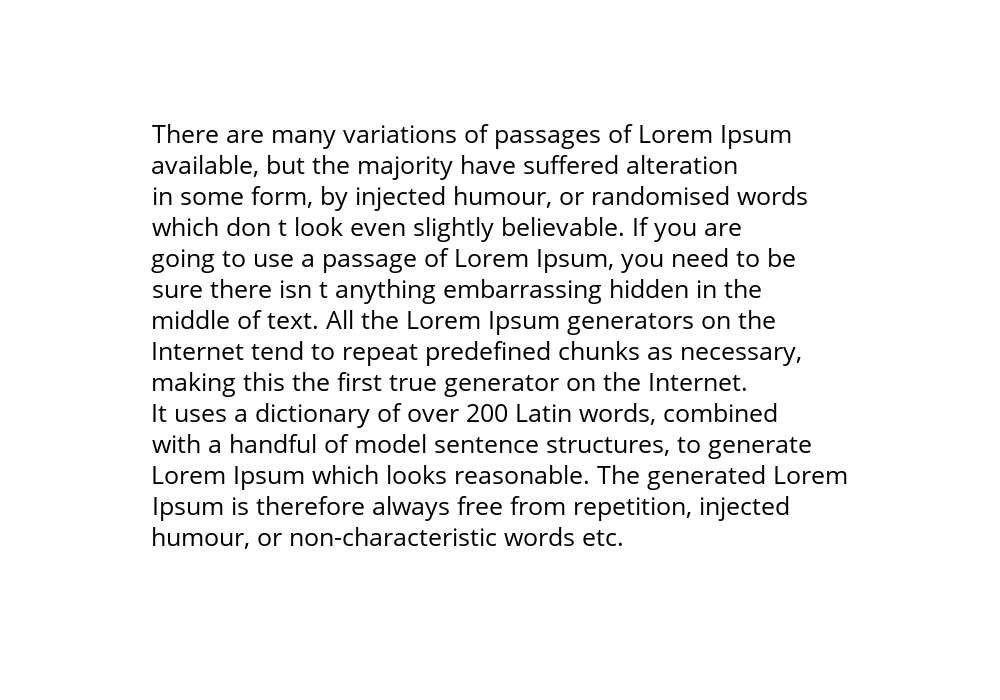

In [568]:
display(out)

In [569]:
result = ocr(out, 'open-sans', f_size)

In [556]:
print(result)

I-I.--r--  .r--    . . .y v .ri ..io .s o- I  .ss .-.--s o- I-or--   . II s..  .
 .v .iI .I I--, I ... .I.--    . .iori.y I. .v-- s..----r--  I  .I. --r ..io .
i . so   .-- -or   ., I y i .i--c. --  I I...  .o..r, or r . . Io   .is--  I ..,or Is
..,I.icI.  Io . . IooI.  --v--  . sIi-.I..Iy I --Ii--v .I I--. I- yo..  .r--
-.oi .-. .o ..s--  . I  .ss .-.-- o- I-or--   . II s..  ., yo..  .----  I .o I --
s..r-- .I.--r-- is . .   . .y.I.i .-. --   .I  .rr .ssi .-. I.i I I--  . i . .I.--
  .i I II-- o- . -- ...  ..II .I.-- I-or--   . II s..  . -.--  .--r ..ors o . .I.--
I .. --r .--. . --  . I .o r--I -- .. I r--  I---i .--  I cI... .I. s  .s  .--c--ss .ry,
  . .I. i .-. .I.is .I.-- -irs. .r..--  -.--  .--r ..or o . .I.-- I .. --r .--..
I. ..s--s  .  Iic.io . .ry o- ov--r .-. . . I-  ..i . ..,or Is, co   .I i .--  I
..,i.I.  . I. . . I-..I o-   .o I--I s--  .. --  .c-- s.r..c...r--s, .o -.--  .--r .. --
I-or--   . II s..  . ..,I.icI. IooI. s r-- .so . .I I--.  I-I.--  -.--  .--r .. --  I I-

In [557]:
import Levenshtein

In [558]:
print(1 - Levenshtein.distance(result, txt) / max(len(result), len(txt)))

0.30434782608695654


In [559]:
def edist_dist2(s1, s2):
    s1 = list(filter(lambda x: x in characters and not x in '.,', list(s1)))
    s2 = list(filter(lambda x: x in characters and x not in '.,', list(s2)))
    return 1 - Levenshtein.distance(s1, s2) / max(len(s1), len(s2))

In [560]:
edist_dist2(result, txt)

0.2996742671009772